In [1]:
# from environmentsettings import setting_categorical
# for loading/processing the images  
import tensorflow as tf
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from keras.applications.mobilenet import preprocess_input

# models 

from keras.applications.vgg16 import VGG16

from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from collections import Counter
import re

In [2]:
# allow multiple output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print("Multiple outputs per cell")

Multiple outputs per cell


In [3]:
images = pd.read_csv('C:/Users/samee/Documents/GitHub/MSOE_ML/datasetsforeverything/NIH.csv')
images.drop(images[images['Finding Labels'].str.contains('\|')].index, inplace=True)

In [4]:
#SET THESE TWO PLS
path = r"C:/Users/samee/Downloads/Saturated-Binary-Single/Train/TrainPA"
p = r"C:/Users/samee/Documents/Imagine Cup Saved Models/Thevindu Cluster"
# change the working directory to the path where the images are located
os.chdir(path)

xrays = {}
temp = []
for disease in os.listdir(path):
    for file in os.listdir(path + "/" + disease):
        if file.endswith(".png"):
            temp.append(file)
    xrays[disease] = temp
    temp = []

#model = tf.keras.applications.mobilenet.MobileNet()
#model = Model(inputs = model.inputs, outputs = model.layer[-1].output)
            
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [5]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model

    imgx = preprocess_input(reshaped_img)
    #imgx = tf.keras.applications.mobilenet.preprocess_input(reshaped_img)
    
       
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [6]:
data = {}


# lop through each image in the dataset
for disease, xray_list in xrays.items():
    # try to extract the features and update the dictionary
    for xray in xray_list:
        try:
            feat = extract_features(os.path.join(path, disease, xray),model)
            data[xray] = feat
        # if something fails, save the extracted features as a pickle file (optional)
        except:
            with open(p,'wb') as file:
                pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are x images of 4096 vectors
feat = feat.reshape(-1,4096)

# get the unique labels (from the flower_labels.csv)
# df = pd.read_csv('flower_labels.csv')
# label = df['label'].tolist()
# unique_labels = list(set(label))

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=69)
pca.fit(feat)
x = pca.transform(feat)

PCA(n_components=100, random_state=69)

In [7]:
#10
kmeans = KMeans(n_clusters=2, random_state=69)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

KMeans(n_clusters=2, random_state=69)

In [8]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        # image = images[images['Image Index'] == file]['Finding Labels'].values[0]
        # print(image)
        disease = re.search(r'^[^\d]*', file).group()[:-1]
        plt.subplot(10,10,index+1);
        img = load_img(os.path.join(path, disease, file))
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')


Clipping cluster size from 272 to 30


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/samee/Downloads/Saturated-Binary-Single/Train/TrainPA\\No Finding\\No Finding 1005.png'

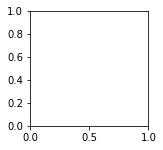

In [9]:
#10
for i in range(2):
    view_cluster(i)

In [11]:
labels = []
for cluster in groups:
    for image in groups[cluster]:
        image = re.search(r'^[^\d]*', image).group()[:-1]
        labels.append(image)
    print(Counter(labels).keys())
    print(pd.Series(labels).value_counts())
    labels = []

dict_keys(['No Finding', 'Pneumonia'])
No Finding    253
Pneumonia     170
dtype: int64
dict_keys(['No Finding', 'Pneumonia'])
No Finding    170
Pneumonia     102
dtype: int64


c:\Users\samee\anaconda3\envs\deeplearningkeras\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


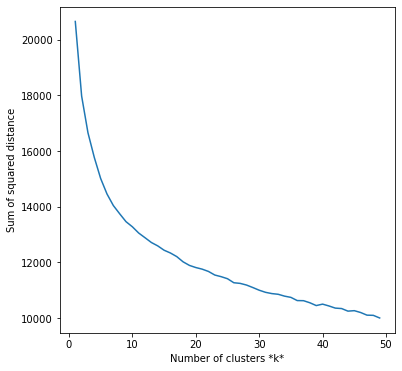

In [12]:
  
   
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(1, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');